### Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

### Random seed setting for repeatability

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Setting device

In [3]:
!nvidia-smi

Wed Feb 21 09:46:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               3W /  30W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataset

In [5]:
np.unique(sns.get_dataset_names()).tolist()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [6]:
# load_dataset() -> Loads an example dataset from the online repository, retuns datafram
df = sns.load_dataset('flights')
df.head(15)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
5,1949,Jun,135
6,1949,Jul,148
7,1949,Aug,148
8,1949,Sep,136
9,1949,Oct,119


In [7]:
df.tail()

,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


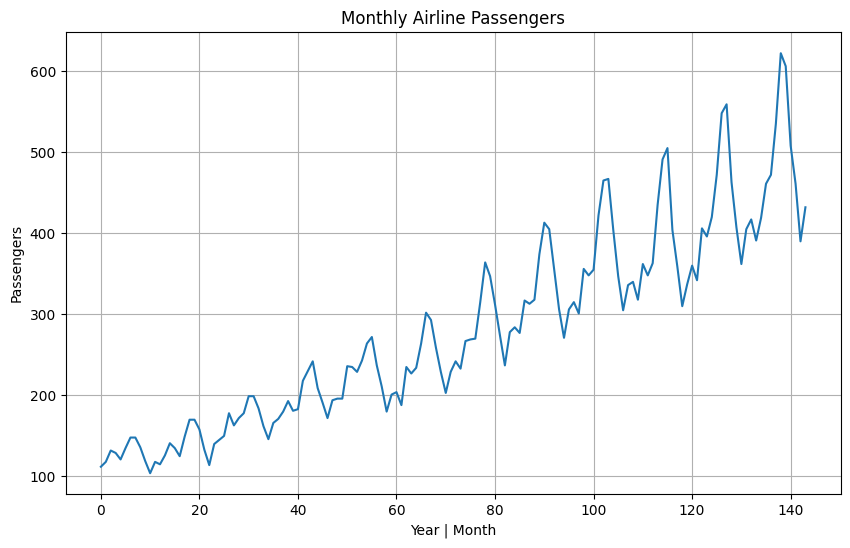

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df['passengers'])
plt.title('Monthly Airline Passengers')
plt.xlabel('Year | Month')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

### Data Prepration for the learning

First we must convert string values to numerical values

In [9]:
passengers = df['passengers'].values.astype('float32')
passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Split data into train, validation, and test sets

In [10]:
train_size = int(0.7 * len(passengers))
val_size = int(0.15 * len(passengers))
test_size = len(passengers) - train_size - val_size
print(f"train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")

train_size: 100, val_size: 21, test_size: 23


In [11]:
train_data = passengers[:train_size].reshape(-1, 1)
valid_data = passengers[train_size:train_size + val_size].reshape(-1, 1)
test_data = passengers[train_size + val_size:].reshape(-1, 1)

Since time-series models is sensitive to the scale of the input data, we need to normalize it so that all input features have a similar scale and prevent some features from dominating the learning process.

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
valid_data_normalized = scaler.transform(valid_data)
test_data_normalized = scaler.transform(test_data)

We can use a many-to-many model to create our sequences.

In [13]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:i+seq_length+1])
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [14]:
seq_length = 8
train_seq = create_sequences(train_data_normalized, seq_length)
train_seq[0].shape, train_seq[1].shape

(torch.Size([92, 8, 1]), torch.Size([92, 8, 1]))

In [15]:
valid_seq = create_sequences(valid_data_normalized, seq_length)
test_seq = create_sequences(test_data_normalized, seq_length)

train_dataset = TensorDataset(train_seq[0], train_seq[1])
val_dataset = TensorDataset(valid_seq[0], valid_seq[1])
test_dataset = TensorDataset(test_seq[0], test_seq[1])

In [16]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model Building

In [17]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=300, output_size=1):
        super().__init__()
        # self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)
        # self.lstm = nn.RNN(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)
        # self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)
        self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size*2, output_size)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = Model().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- The output `nn.LSTM()` is a tuple. The first element is the hidden states generated, one for each timestep of the input. The second element is the memory and hidden states of the LSTM cell and is not used here.

- The LSTM layer is created with the `batch_first=True` option because the tensors you prepare are of size (window sample, timesteps, features) and a batch is created by sampling in the first dimension.

In [18]:
from torchinfo import summary

summary(model, input_size=(8, 8, 1), col_names=["input_size", "output_size", "num_params"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
Model                                    [8, 8, 1]            [8, 8, 1]            --
├─GRU: 1-1                               [8, 8, 1]            [8, 8, 600]          545,400
├─Linear: 1-2                            [8, 8, 600]          [8, 8, 1]            601
Total params: 546,001
Trainable params: 546,001
Non-trainable params: 0
Total mult-adds (M): 34.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 2.18
Estimated Total Size (MB): 2.49

In [19]:
from train import train

train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/3000, Training Loss: 0.15502, Validation Loss: 0.33764
Epoch 50/3000, Training Loss: 0.00604, Validation Loss: 0.02039
Epoch 100/3000, Training Loss: 0.00287, Validation Loss: 0.00982
Epoch 150/3000, Training Loss: 0.00266, Validation Loss: 0.01054
Epoch 166/3000, Training Loss: 0.00260, Validation Loss: 0.01126
Epoch 136/3000, Training Loss: 0.00260, Validation Loss: 0.00968
Early stopping at epoch 166, best model weights are saved at the 136 epoch


### Plotting Train and Validation Losses

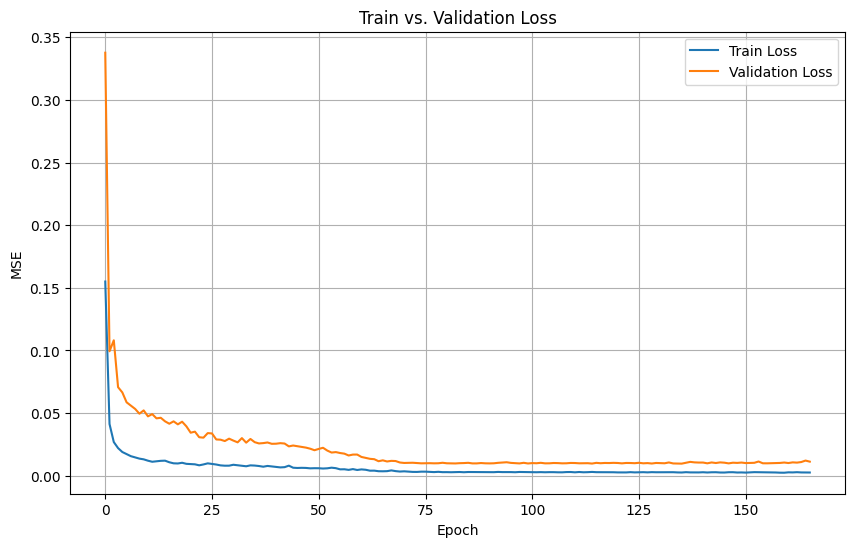

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from test import test

test(model, criterion, test_loader, device)

Test Loss: 0.02169198


### Plotting Actual vs Predicted Passengers

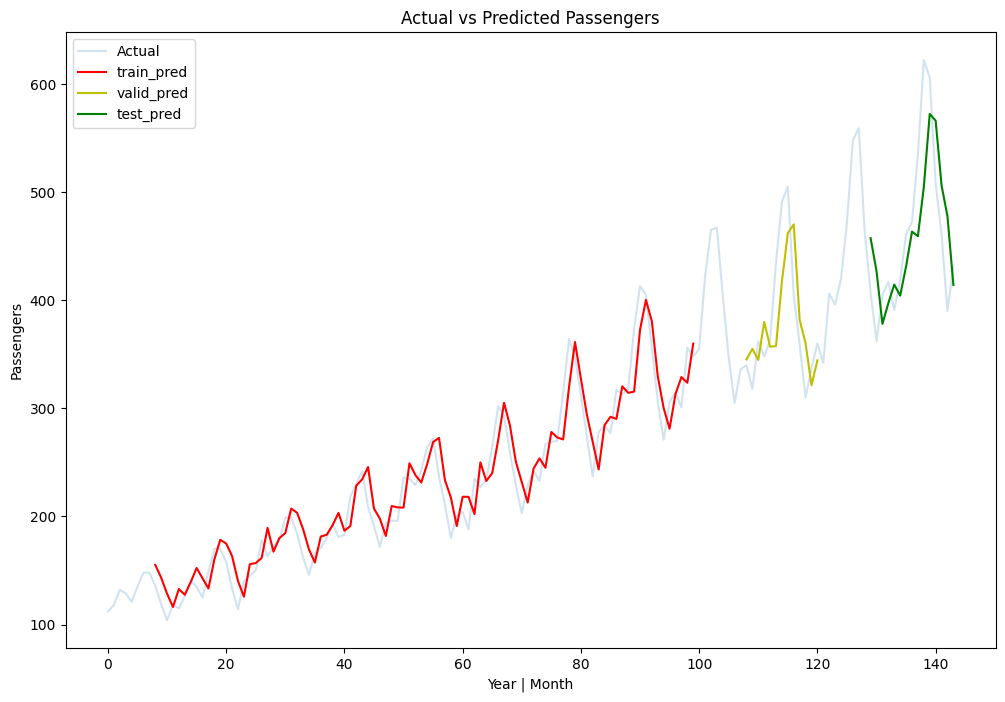

In [22]:
with torch.inference_mode():
    train_plot = np.ones_like(passengers) * np.nan
    train_plot[seq_length:train_size] = model(train_seq[0].to(device)).detach().cpu().numpy()[:, -1, :].reshape(-1)
    
    valid_plot = np.ones_like(passengers) * np.nan
    valid_plot[train_size+seq_length:len(passengers) - test_size] = model(valid_seq[0].to(device)).detach().cpu().numpy()[:, -1, :].reshape(-1)
    
    test_plot = np.ones_like(passengers) * np.nan
    test_plot[train_size+val_size+seq_length:len(passengers)] = model(test_seq[0].to(device)).detach().cpu().numpy()[:, -1, :].reshape(-1)

plt.figure(figsize=(12, 8))
plt.plot(passengers, label='Actual', alpha=0.2)
plt.plot(scaler.inverse_transform(train_plot.reshape(-1, 1)), label='train_pred', c='r')
plt.plot(scaler.inverse_transform(valid_plot.reshape(-1, 1)), label='valid_pred', c='y')
plt.plot(scaler.inverse_transform(test_plot.reshape(-1, 1)), label='test_pred', c='g')

plt.title("Actual vs Predicted Passengers")
plt.xlabel('Year | Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

[LSTM for Time Series Prediction in PyTorch](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/) was utilized for this small project.